In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [3]:
import pickle
import keras_tuner
# Open the pickle file for reading
path_best_params = "../.cache/param_search/all_data_20231116-050822.pkl"

with open(path_best_params, 'rb') as file:
    # Load the data from the file
    best_params = pickle.load(file)

# Now 'data' contains the contents of the pickle file
best_params.values

{'model_type': 'lstm-stacked',
 'lstm_vanilla_units': 65,
 'dropout': True,
 'dense_units': 130,
 'lr': 0.000256573859028217,
 'lstm_stacked_1_units': 50,
 'lstm_stacked_2_units': 85,
 'tuner/epochs': 9,
 'tuner/initial_epoch': 3,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0010',
 'lstm_bidirectional_units': 75}

In [15]:
import sys
sys.path.append("..")

# Environment configuration
import raw_data_manager.raw_data_acquisition as rda
import raw_data_manager.raw_data_inspector as rdi
import raw_data_manager.raw_data_splitter as rds
from data_exploration.metric_acquisition import MetricAcquisition
from data_preparation.transformation_manager import TransformationManager
from constants import storage_config
import pathlib
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt


# Set default logging level.
from absl import logging
logging.set_verbosity(logging.DEBUG)

In [12]:
# Get transformed files paths
TRANSFORMATION_NAME_PREFIX = "transform-isdt-"
train_tranformed_folder_name = "dataset_converted_v10101_split-20_source-all_class-all_well-all_train"
test_tranformed_folder_name = "dataset_converted_v10101_split-20_source-all_class-all_well-all_test"
validation_tranformed_folder_name = "dataset_converted_v10101_split-20_source-all_class-all_well-all_validation"

train_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + train_tranformed_folder_name)
validation_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + validation_tranformed_folder_name)
test_tranformed_dataset_dir = storage_config.DIR_PROJECT_DATA / (TRANSFORMATION_NAME_PREFIX + test_tranformed_folder_name)

# Generate inspectors for the transformed data
train_inspector_converted = rdi.RawDataInspector(
    train_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-train.parquet",
    use_cached=False
)
validation_inspector_transformed = rdi.RawDataInspector(
    validation_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-validation.parquet",
    use_cached=False
)
test_inspector_transformed = rdi.RawDataInspector(
    test_tranformed_dataset_dir,
    storage_config.DIR_PROJECT_CACHE / "all_wells_transformed-test.parquet",
    use_cached=False
)

# Get list of paths for the events in each of the data groups (train, val, test)
train_metadata_converted = train_inspector_converted.get_metadata_table()
train_transformed_file_path_list = train_metadata_converted["path"].to_list()

validation_metadata_transformed = validation_inspector_transformed.get_metadata_table()
validation_transformed_file_path_list = validation_metadata_transformed["path"].to_list()

test_metadata_transformed = test_inspector_transformed.get_metadata_table()
test_transformed_file_path_list = test_metadata_transformed["path"].to_list()

# shuffle
random.shuffle(train_transformed_file_path_list)
random.shuffle(validation_transformed_file_path_list)
random.shuffle(test_transformed_file_path_list)

INFO:absl:Processing 416 events of class type 0.
DONE: 100%|██████████| 416/416 [00:00<00:00, 2346.61it/s]
INFO:absl:Processing 241 events of class type 4.
DONE: 100%|██████████| 312/312 [00:00<00:00, 1902.79it/s]
INFO:absl:Processing 89 events of class type 1.
DONE: 100%|██████████| 89/89 [00:00<00:00, 640.50it/s]
INFO:absl:Processing 9 events of class type 7.
DONE: 100%|██████████| 23/23 [00:00<00:00, 283.33it/s]
INFO:absl:Processing 74 events of class type 3.
DONE: 100%|██████████| 74/74 [00:00<00:00, 524.16it/s]INFO:absl:Found 9.

INFO:absl:Processing 59 events of class type 0.
DONE: 100%|██████████| 59/59 [00:00<00:00, 454.08it/s]INFO:absl:Processing 34 events of class type 4.

DONE: 100%|██████████| 34/34 [00:00<00:00, 222.83it/s]
INFO:absl:Processing 45 events of class type 5.
DONE: 100%|██████████| 45/45 [00:00<00:00, 303.32it/s]
INFO:absl:Processing 13 events of class type 1.
DONE: 100%|██████████| 4/4 [00:00<00:00, 24.24it/s]
INFO:absl:Processing 10 events of class type 3.
DO

In [13]:
train_data_gen = TransformationManager.data_generator_loop(train_transformed_file_path_list)
validation_data_gen = TransformationManager.data_generator_loop(validation_transformed_file_path_list)
test_data_gen = TransformationManager.data_generator_loop(test_transformed_file_path_list)

In [8]:
from tensorflow import keras, math
import keras_tuner
from raw_data_manager.models import EventClassType

In [9]:
num_features = 6
num_outputs = len(EventClassType)

transformation_param_sample_interval_seconds=60
transformation_param_num_timesteps_for_window=20

def build_model(hp: keras_tuner.HyperParameters):
    model_type = hp.Choice("model_type", 
                           ["lstm-vanilla", 
                            "lstm-stacked", 
                            "lstm-bidirectional"])

    model = keras.Sequential()
    match model_type:
        case "lstm-vanilla":
            model.add(keras.layers.LSTM(
                hp.Int('lstm_vanilla_units', min_value=5, max_value=100, step=5), 
                activation='relu', 
                input_shape=(transformation_param_num_timesteps_for_window, num_features)))
        case "lstm-stacked":
            model.add(keras.layers.LSTM(
                hp.Int('lstm_stacked_1_units', min_value=5, max_value=100, step=5), 
                activation='relu', 
                return_sequences=True,
                input_shape=(transformation_param_num_timesteps_for_window, num_features)))
            
            model.add(keras.layers.LSTM(
                hp.Int('lstm_stacked_2_units', min_value=5, max_value=100, step=5), 
                activation='relu', ))
        case "lstm-bidirectional":
            model.add(keras.layers.Bidirectional(keras.layers.LSTM(
                hp.Int('lstm_bidirectional_units', min_value=5, max_value=100, step=5), 
                activation='relu', 
                input_shape=(transformation_param_num_timesteps_for_window, num_features))))
            
    if hp.Boolean("dropout"):
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Dense(
        hp.Int('dense_units', min_value=20, max_value=200, step=10),
        activation='relu'))
    
    model.add(keras.layers.Dense(num_outputs, activation='softmax'))

    # compiling model
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-1, sampling="log")
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
        metrics=['accuracy'],
    )
    return model

# check the model can compile
build_model(keras_tuner.HyperParameters())

In [14]:
best_model = build_model(best_params)

# Training configurations
num_epochs = 50
steps_per_epoch = len(train_transformed_file_path_list)
train_data_gen = TransformationManager.data_generator_loop(train_transformed_file_path_list)
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

checkpoint_filepath = storage_config.DIR_PROJECT_CACHE / "model_weights" / "weights.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint_filepath.parent.mkdir(parents=True, exist_ok=True)
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

training_history = best_model.fit(
    train_data_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    validation_data=validation_data_gen,
    validation_steps=len(validation_transformed_file_path_list),
    callbacks=[early_stopping_callback, model_checkpoint_callback],
    verbose=1
)

Epoch 1/50
1375/1375 [==============================] - 100s 71ms/step - loss: 1.2782 - accuracy: 0.5816 - val_loss: 0.7222 - val_accuracy: 0.8064
Epoch 2/50
1375/1375 [==============================] - 95s 69ms/step - loss: 0.6438 - accuracy: 0.8105 - val_loss: 0.6634 - val_accuracy: 0.8210
Epoch 3/50
1375/1375 [==============================] - 95s 69ms/step - loss: 0.4505 - accuracy: 0.8570 - val_loss: 0.5471 - val_accuracy: 0.8623
Epoch 4/50
1375/1375 [==============================] - 95s 69ms/step - loss: 0.4400 - accuracy: 0.8647 - val_loss: 0.4262 - val_accuracy: 0.8861
Epoch 5/50
1375/1375 [==============================] - 95s 69ms/step - loss: 0.3512 - accuracy: 0.8818 - val_loss: 0.4922 - val_accuracy: 0.9357
Epoch 6/50
1375/1375 [==============================] - 95s 69ms/step - loss: 0.3295 - accuracy: 0.8907 - val_loss: 0.6366 - val_accuracy: 0.9189
Epoch 7/50
1375/1375 [==============================] - 95s 69ms/step - loss: 0.3031 - accuracy: 0.9033 - val_loss: 0.8892 

NameError: name 'plt' is not defined

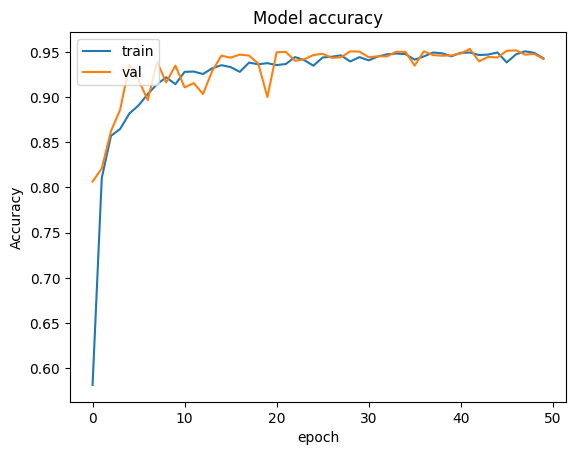

In [16]:
# Graph of training results history
plt.plot(training_history.history['accuracy'])
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [17]:
with open('melhor_modelo_ever_all_data.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [18]:
test_data_gen = TransformationManager.data_generator_non_loop(test_transformed_file_path_list)
num_steps = len(test_transformed_file_path_list)

best_model.evaluate(
    test_data_gen,
    steps=num_steps,
    verbose=1,
)

395/395 [==============================] - 15s 38ms/step - loss: 1.4804 - accuracy: 0.9328


[1.4804333448410034, 0.9328254461288452]